The following paper covers multiple points of Supervised Machine Learning Classifier. We will take a look at: 
* Feature and target correlation and importance;
* Data scaling to reduce the computation time and weight;
* Dimensionality reduction and its effect;
* Application of different models and its effect on our train and test dataset; 
* Analyzing the effectivness of the model via metrics. 

Source dataset: https://www.kaggle.com/iabhishekofficial/mobile-price-classification


Prior to initiliazing the work, my personal believe that there is a correlation between the price of mobile phone and specifications, my personal believe is that the processor will play a big role as it has been marketed heavily to the users. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
import util
import pathlib

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
sns.set_theme()

I have developed a personal `util.py` to store the repetive code and improve the astetics and readability of the notebook for user. Despite that I will provide a basic explanation on what each function does without diving too much into the code.

If one wishes to dive deeper into the `util.py` one may do so. 

In [2]:
mpc_train = pd.read_csv(pathlib.Path().joinpath('data', 'train.csv'))
mpc_test = pd.read_csv(pathlib.Path().joinpath('data', 'test.csv')).set_index('id')

Once I've imported the datasets and have constructed a DataFrame for each we can view the correlation between the features and our target (`"price_range"`).

Text(0, 0.5, 'Correlation')

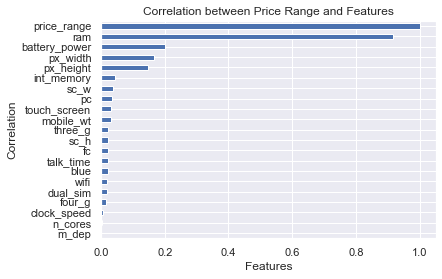

In [3]:
mpc_train.corr()['price_range'].apply(np.abs).sort_values().plot.barh()
plt.title("Correlation between Price Range and Features"); plt.xlabel('Features'); plt.ylabel('Correlation')

To my big surprise the `n_cores` and others features of the chip has not been a significant enough influence on the correlation. We may say that the ram is directly depending on the SOC (processor).

>"Faster CPU results into speedier operations. By operations, I mean the speed of opening apps, the speed with which a click responds and other things.
> More RAM results into better multitasking. Frequently used apps and app data is stored into RAM."
> -- <cite> Asif Iqbal Shaik - https://www.quora.com/Which-one-should-I-prefer-while-buying-a-new-mobile-a-RAM-or-a-processor</cite>

Based on this information we can agree that the highest correlation features of our `price_range` would be RAM, Battery Power and Display.

At this point we would like to perform scaling on our `DataFrames` to reduce the computation. As our `DataFrames` do not have label data we will just perform `MinMaxScaler` on all features, except target. 


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_columns = [column for column in mpc_train.columns if column != 'price_range']

mpc_train[scaler_columns] = scaler.fit_transform(mpc_train[scaler_columns])

In [5]:
mpc_train.price_range.value_counts(normalize=True)

0    0.25
1    0.25
2    0.25
3    0.25
Name: price_range, dtype: float64

We can see that our class distribution is balanced that reduces our requirements to work with imbalanced class dataset and perform any modifications on it to either Upsample or Downsample. 

Once we are complete we can split our `DataFrames` into train and test, and later structing the `DataFrame` which we will predict, that does not have target column (`price_range`), hence, our predict `DataFrame`

In [6]:
from sklearn.model_selection import train_test_split

target_column = 'price_range'
feature_columns = [column for column in mpc_train.columns if column != target_column]

X, y = mpc_train[feature_columns], mpc_train[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_validation = pd.DataFrame(scaler.fit_transform(mpc_test), columns=scaler_columns)

Once the EDA process has been complete it is time to build a model, I have opted to first use Support Vectore Machine classifier and performing GridSearchCV to understand which would be the best parameters. 

Later on I will utilize the `util.py` that will construct the `classification_report`, `confusion_matrix` and showcase the decision boundary of our two highest correlation features (`ram` and `battery_power`).

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1}

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       117
           1       0.85      0.92      0.88       121
           2       0.92      0.92      0.92       145
           3       0.98      0.94      0.96       117

    accuracy                           0.92       500
   macro avg       0.93      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



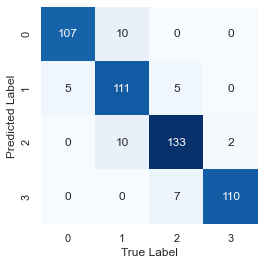

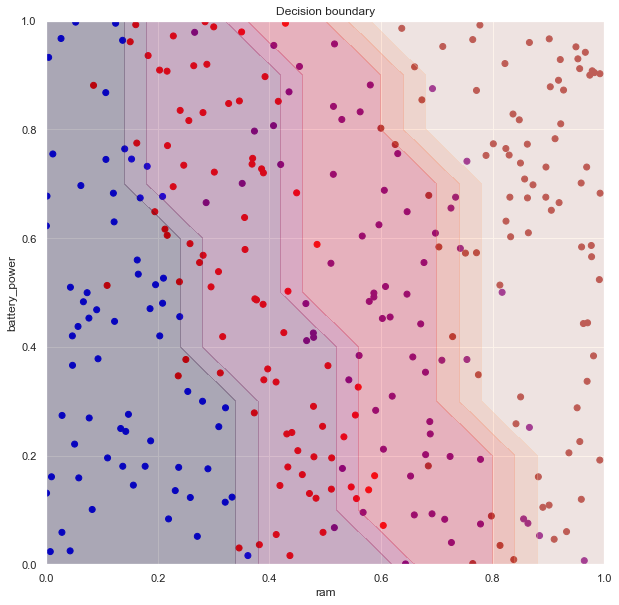

In [7]:
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# params = [{'C': [0.001, 0.01, 0.1, 1], 
#            'kernel': ['rbf', 'poly', 'sigmoid'],
#            'max_iter': [-1, 1, 10, 100],
#            'gamma': [0.1, 1, 10, 100]}]

# svm = GridSearchCV(SVC(), params, n_jobs=-1)
# svm.fit(X_train, y_train)

# pickle.dump(svm, open(pathlib.Path().joinpath('pickle', 'svc_grid.pickle'), 'wb'))

svm = pickle.load(open(pathlib.Path().joinpath('pickle', 'svc_grid.pickle'), 'rb'))

display(svm.best_params_)

util.metrics_display(svm, X_test, y_test)

util.decision_plotted(svm, X, y, ['ram', 'battery_power'])

Based on the `classification_report` we can see that the F1 score averaged out on the 93%, this means that 93% of the data has been classified correctly. 

In the `confusion_matrix` we can see that the model predict majority of the classes correctly. One may see that the there are number of outliers in each class that leak onto neighbouring classes. 

The *Descision boundary* graph provided is not perfect as it is quite challenging displaying mutli-dimensional features in 2D graph. Despite that two of the highest correlation features have been used to display the decision boundary between multiple classes. Based on the graph we can see that there is certain leak happening from our neighbouring classes. **Again it would like to be noted tha this graph does not represent the full decision boundary between the classes!**

After the model computation completion one can view the feature importance of each feature to the `price_range` (target). 

In [8]:
from sklearn.inspection import permutation_importance

model = SVC().set_params(**svm.best_params_)
model.fit(X_train, y_train)

# importance = permutation_importance(model, X_test, y_test)
# pickle.dump(importance, open(pathlib.Path().joinpath('pickle', 'importance.pickle'), 'wb'))

importance = pickle.load(open(pathlib.Path().joinpath('pickle', 'importance.pickle'), 'rb'))
feature_names = X_test.columns

index = importance.importances_mean.argsort()



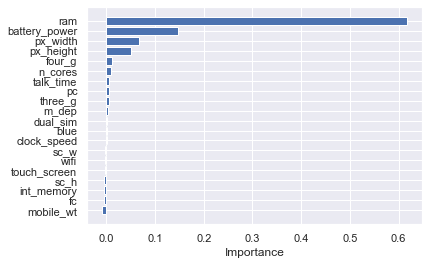

In [9]:
plt.barh(feature_names[index], importance.importances_mean[index])
plt.xlabel('Importance')
plt.show()

As seen above `ram` and `battery_power` are the highest influencers of the `price_range` (target). 

At this point it would be interesting to understand what are the effects of reducing the dimensions (removing features). 

This can be perofrmed as simple as `DataFrame` slicing, at this point the highest influencers are `['ram', 'battery_power', 'px_width', 'px_height']` and those will be used to see the effects.

In [10]:
importance_ = pd.DataFrame(importance.importances_mean[index], feature_names[index], columns=['Importance']).sort_values(by=['Importance'], ascending=False)

features_use = importance_.head(4).index.tolist()
X_sliced = X[features_use]
X_train_sliced, X_test_sliced, y_train_sliced, y_test_sliced = train_test_split(X_sliced, y)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       112
           1       0.94      0.94      0.94       117
           2       0.95      0.95      0.95       134
           3       0.99      0.96      0.98       137

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



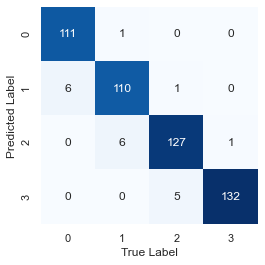

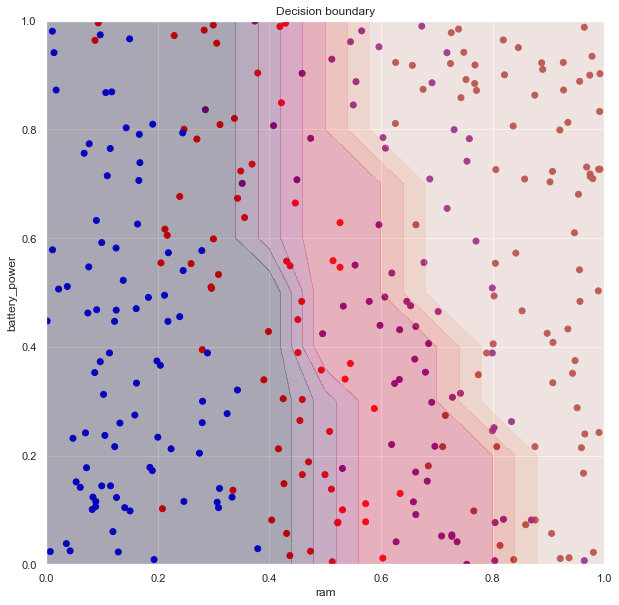

In [11]:
svm_sliced = SVC().set_params(**svm.best_params_)
svm_sliced.fit(X_train_sliced, y_train_sliced)

util.metrics_display(svm_sliced, X_test_sliced, y_test_sliced)

util.decision_plotted(svm_sliced, X_sliced, y, ['ram', 'battery_power'])


We can see that the effect of lowering the dimensions improved the overall F1 Score, hence, making the model a bit more simpler, and reducing our computation time and weight.

`SVM` provided interesting results, however, there are more models that be tried to find the best solution for the dataset. 

At this moment there will be introduction of `Ensemble` models. 

The first step would be to find the optimal base condition model, in order to save computation power and time. 

Yet again, the `util.py` has been been constructed to assist in the following issue by building each model and providing an error based on the number of trees used. 

In [12]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

trees_num = 500

forest = util.trees_oob_error(RandomForestClassifier(n_jobs=-1, oob_score=True, warm_start=True), X, y, trees_num)
extra_trees = util.trees_oob_error(ExtraTreesClassifier(n_jobs=-1, oob_score=True, warm_start=True, bootstrap=True), X, y, trees_num)
bagging = util.trees_oob_error(BaggingClassifier(n_jobs=-1, oob_score=True), X, y, trees_num)
gradient_boosting = util.trees_accuracy_error(GradientBoostingClassifier(), X, y, trees_num)
ada_boosting = util.trees_accuracy_error(AdaBoostClassifier(learning_rate=0.9), X, y, trees_num)


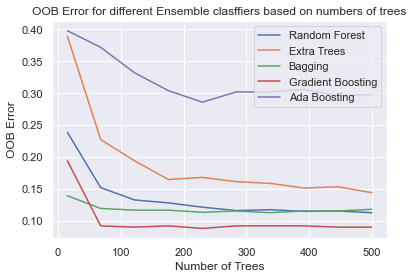

In [13]:
plt.plot(forest, label='Random Forest'), plt.plot(extra_trees, label='Extra Trees')
plt.plot(bagging, label='Bagging'), plt.plot(gradient_boosting, label='Gradient Boosting')
plt.plot(ada_boosting, label='Ada Boosting')
plt.title('OOB Error for different Ensemble clasffiers based on numbers of trees')
plt.xlabel('Number of Trees'), plt.ylabel('OOB Error'), plt.legend()
plt.show()

It can be seen that at the current moment the worst unoptimized model is `AdaBoostClassifier` with the best one being `GradientBoostingClassifier`. 

Based on the base results `GradientBoostingClassifier` will be used to perform our model construction as it had the best unoptimized results. 

At the current moment it will be good to start analyzing what would the best features for the `GradientBoostingClassifier`.

In [14]:
# params={
#     'learning_rate': np.linspace(0.1, 1, 5),
#     'max_depth': [3, 10, 20, 40],
#     'warm_start': [True, False]
# }

# gradient_grid = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1)
# gradient_grid.fit(X_train, y_train)

# pickle.dump(gradient_grid, open(pathlib.Path().joinpath('pickle', 'gradient_grid.pickle'), 'wb'))

gradient_grid = pickle.load(open(pathlib.Path().joinpath('pickle', 'gradient_grid.pickle'), 'rb'))

In [15]:
gradient_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'warm_start': True}

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       117
           1       0.94      0.98      0.96       121
           2       0.97      0.96      0.97       145
           3       0.99      0.97      0.98       117

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



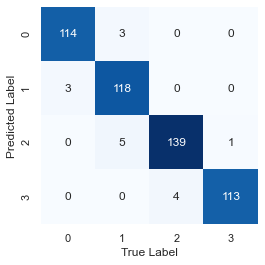

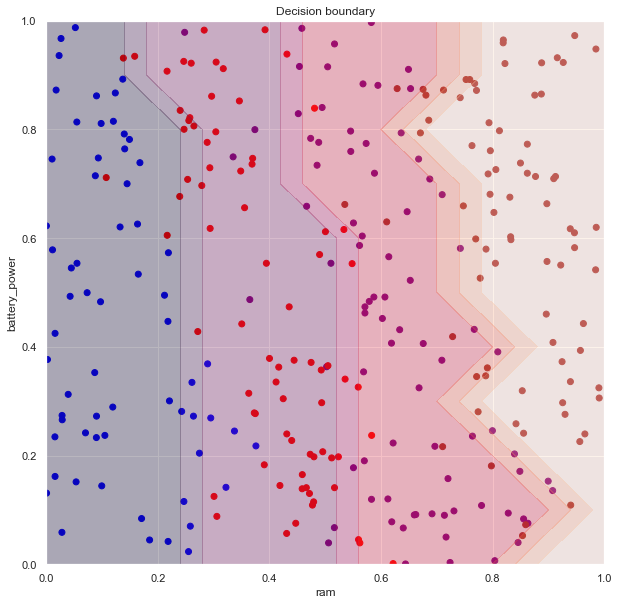

In [16]:
# gradient = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3)
# gradient.fit(X_train, y_train)

# pickle.dump(gradient, open(pathlib.Path().joinpath('pickle', 'gradientboosting.pickle'), 'wb'))

gradient = pickle.load(open(pathlib.Path().joinpath('pickle', 'gradientboosting.pickle'), 'rb'))

util.metrics_display(gradient, X_test, y_test)

util.decision_plotted(gradient, X, y, ['ram', 'battery_power'])


Based on the F1 score it can be seen that `GradientBoostingClassifier` has performed much better than `SVC` with difference of 0.03; 0.98 to 0.95. 

Additionally, it can be seen based on the `confusion_matrix` that the `GradientBoostingClassifier` has predicted much more values correctly, in comparison to `SVC`. 

In [17]:
print("Gradient Score: ", gradient.score(X_test, y_test))
print("SVM Score: ", svm.score(X_test, y_test))

Gradient Score:  0.968
SVM Score:  0.922


The last step would be to apply all our gathered information on the actual dataset that would need to be predicted. 

<AxesSubplot:>

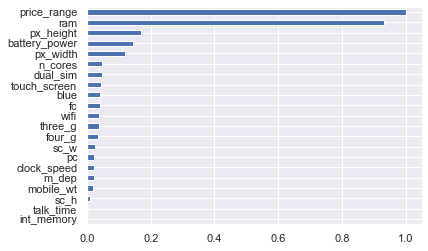

In [18]:
result_df = X_validation.copy()
result_df['price_range'] = gradient.predict(X_validation)
result_df.corr()['price_range'].apply(np.abs).sort_values().plot.barh()

In [19]:
result_df['price_range'].value_counts(normalize=True).sort_index()

0    0.250
1    0.238
2    0.254
3    0.258
Name: price_range, dtype: float64

In [20]:
result_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0.362241,1.0,0.52,1.0,0.736842,0.0,0.048387,0.000000,0.941667,0.285714,...,0.118511,0.608550,0.862319,0.500000,0.388889,0.000000,0.0,1.0,0.0,3
1,0.227485,1.0,0.00,1.0,0.210526,1.0,0.951613,0.777778,0.925000,0.571429,...,0.391190,0.237809,0.974772,0.071429,0.000000,0.277778,1.0,0.0,0.0,3
2,0.871915,1.0,0.92,0.0,0.052632,0.0,0.403226,0.888889,0.883333,0.285714,...,0.665967,0.577822,0.572464,0.857143,0.555556,0.444444,0.0,1.0,1.0,2
3,0.697799,0.0,0.00,1.0,0.947368,1.0,0.370968,0.444444,0.133333,1.000000,...,0.154693,0.835671,0.974235,0.357143,0.000000,0.277778,1.0,1.0,0.0,3
4,0.623082,0.0,0.36,0.0,0.578947,1.0,0.758065,0.444444,0.233333,0.714286,...,0.392764,0.206413,0.405260,0.714286,0.444444,0.277778,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.800534,1.0,0.56,0.0,0.000000,1.0,0.838710,0.444444,0.750000,0.857143,...,0.337703,0.275217,0.498658,0.642857,0.444444,0.722222,1.0,1.0,0.0,2
996,0.072715,0.0,0.52,1.0,0.000000,0.0,0.177419,0.888889,0.883333,0.428571,...,0.604090,0.755511,0.448202,0.214286,0.055556,0.944444,0.0,1.0,1.0,1
997,0.456971,0.0,0.36,0.0,0.052632,1.0,0.096774,0.444444,0.000000,0.000000,...,0.250131,0.216433,0.257649,0.000000,0.000000,0.666667,1.0,0.0,0.0,0
998,0.689126,1.0,0.00,1.0,0.000000,0.0,0.774194,0.333333,0.758333,0.142857,...,0.019927,0.221109,0.602791,0.714286,0.611111,0.222222,0.0,1.0,0.0,2


Conclusion:

Based on the gathered information it can be seen that there are multiple factors effecting the `price_range`, however, the initial hypothesis of processor's effect on the `price_range` was not as significant as it was expected. 

Based on the dataset provided the model has predicted relatively well distribution `price_range` and showcased the importance of `ram` and `battery_power` on the `price_range`. 